In [1]:
# Nagel-Schreckenberg Model Class
import matplotlib.pyplot as plt
import random

class Nagel_Schreckenberg:
    def __init__(self, road_length, num_cars, max_speed, slowdown_prob):
        self.road_length = road_length
        self.num_cars = num_cars
        self.max_speed = max_speed
        self.slowdown_prob = slowdown_prob
        self.road = [-1] * road_length
        self.speeds = [-1] * road_length
        self.positions = []
        self.dangerous_situations = 0
        self.cars_crossed = 0
        self.initialized = False

        # Initialize positions and speeds
        car_positions = random.sample(range(road_length), num_cars)
        for pos in car_positions:
            self.road[pos] = 0
            self.speeds[pos] = random.randint(0, max_speed)
            self.positions.append(pos)

    def update(self):
        new_road = [-1] * self.road_length
        new_speeds = [-1] * self.road_length
        new_positions = []

        for pos in self.positions:
            speed = self.speeds[pos]
            # Rule 1: Acceleration
            if speed < self.max_speed:
                speed += 1
            # Rule 2: Deceleration
            distance = 1
            while distance <= speed and (pos + distance) % self.road_length not in self.positions:
                distance += 1
            speed = min(speed, distance - 1)
            # Rule 3: Randomization
            if random.random() < self.slowdown_prob:
                if speed > 0:
                    speed -= 1
            # Rule 4: Move cars
            new_pos = (pos + speed) % self.road_length

            # Check for flow (cars crossing the border)
            if pos < self.road_length - 6 and new_pos >= self.road_length - 6: #cars crossed calculation
                self.cars_crossed += 1

            # Check for dangerous situations
            if self.initialized:
                next_pos = (new_pos + 1) % self.road_length
                distance_to_next_car = (next_pos - new_pos) % self.road_length
                if (self.road[next_pos] != -1 and
                    self.speeds[next_pos] > 0 and
                    new_speeds[next_pos] == 0 and
                    distance_to_next_car < self.max_speed and
                    speed >= distance_to_next_car - 1):
                    self.dangerous_situations += 1

            new_road[new_pos] = 0
            new_speeds[new_pos] = speed
            new_positions.append(new_pos)

        self.road = new_road
        self.speeds = new_speeds
        self.positions = new_positions
        self.initialized = True

        return self.cars_crossed, self.dangerous_situations

    def __repr__(self):
        return ''.join('.' if car == -1 else str(self.speeds[i]) for i, car in enumerate(self.road))

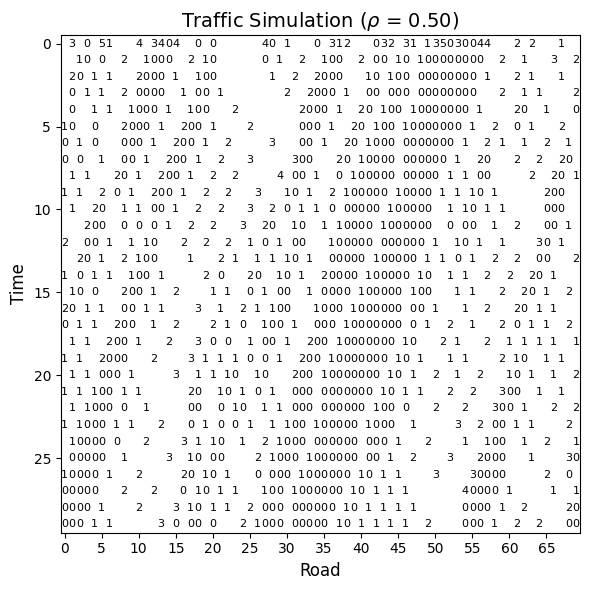

In [2]:
# Overview of the road in NS model
# Parameters
road_length = 70
num_cars = 35
max_speed = 5
slowdown_prob = 0.3

# Calculate density
density = num_cars / road_length

# Initialize model
traffic_model = Nagel_Schreckenberg(road_length, num_cars, max_speed, slowdown_prob)

# Simulation and visualization
simulation = []
for _ in range(30):
    row = [traffic_model.speeds[i] if traffic_model.speeds[i] != -1 else -1 for i in range(traffic_model.road_length)]
    simulation.append(row)
    traffic_model.update()

simulation_text = [['.' if speed == -1 else str(speed) for speed in row] for row in simulation]

plt.figure(figsize=(6, 6))
for t, row in enumerate(simulation_text):
    for pos, value in enumerate(row):
        if value != '.':
            plt.text(pos, t, value, ha='center', va='center', fontsize=8, color='black')

plt.xlim(-0.5, road_length - 0.5)
plt.ylim(-0.5, len(simulation) - 0.5)
plt.gca().invert_yaxis()
plt.xticks(range(0, road_length, 5))
plt.yticks(range(0, len(simulation), 5))
plt.xlabel("Road", fontsize=12)
plt.ylabel("Time", fontsize=12)
plt.title(r"Traffic Simulation ($\rho$ = {:.2f})".format(density), fontsize=14)
plt.tight_layout()

plt.show()

In [3]:
# Parameters of Simulations
road_length = 100
max_speed = 5
slowdown_prob = 0.3
iterations = 300 #number of time steps
num_simulations = 100 #number of simulations for averaging
density_step = 5

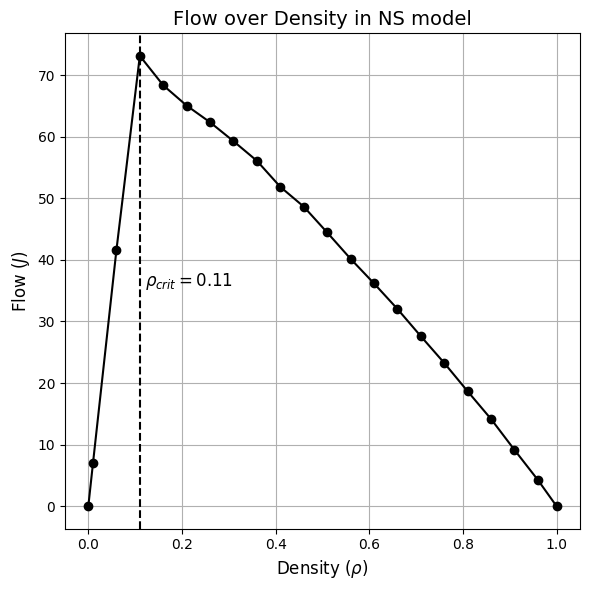

In [4]:
# Flow over Density dependence
flows = [0]
densities = [0]

for num_cars in range(1, road_length + 1, density_step):
    average_flow = 0

    for _ in range(num_simulations):
        traffic_model = Nagel_Schreckenberg(road_length, num_cars, max_speed, slowdown_prob)
        total_cars_crossed = 0

        for _ in range(iterations):
            cars_crossed, _ = traffic_model.update()
            total_cars_crossed += cars_crossed

        flow = total_cars_crossed / iterations
        average_flow += flow

    average_flow /= num_simulations
    density = num_cars / road_length

    flows.append(average_flow)
    densities.append(density)

flows.append(0)
densities.append(1)

plt.figure(figsize=(6, 6))
plt.plot(densities, flows, marker='o', linestyle='-', color='black')

max_flow = max(flows)
rho_crit = densities[flows.index(max_flow)]

plt.axvline(x=rho_crit, color='black', linestyle='--')

plt.text(rho_crit + 0.01, max_flow/2, r'$\rho_{{crit}} = {:.2f}$'.format(rho_crit), verticalalignment='center', fontsize=12, color='black')

plt.xlabel(r'Density ($\rho$)', fontsize=12)
plt.ylabel(r'Flow ($J$)', fontsize=12)
plt.title("Flow over Density in NS model", fontsize=14)
plt.tight_layout()
plt.grid(True)
plt.show()


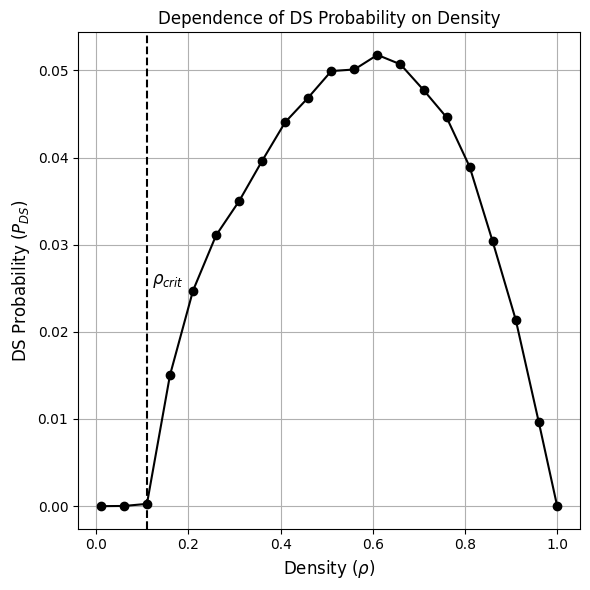

In [5]:
# Dangerous situation probability over density dependence
# Function to calculate the probability of dangerous situations
def simulate_probability(road_length, max_speed, slowdown_prob, densities, iterations=100, num_simulations=50):
    probabilities = []

    for density in densities:
        num_cars = int(density * road_length)
        avg_dangerous_prob = 0

        for _ in range(num_simulations):
            ns_model = Nagel_Schreckenberg(road_length, num_cars, max_speed, slowdown_prob)

            ns_model.dangerous_situations = 0

            for _ in range(iterations):
                ns_model.update()

            total_cases = num_cars * iterations
            avg_dangerous_prob += (ns_model.dangerous_situations / total_cases if total_cases > 0 else 0)

        probabilities.append(avg_dangerous_prob / num_simulations)

    return probabilities

# Conducting the simulation for dangerous situations probability
densities = [num_cars / road_length for num_cars in range(1, road_length + 1, density_step)]
probabilities = simulate_probability(road_length, max_speed, slowdown_prob, densities, iterations)

densities.append(1)
probabilities.append(0)

# Plotting the graph for dangerous situations probability
plt.figure(figsize=(6, 6))
plt.plot(densities, probabilities, marker='o', linestyle='-', color='black')
plt.axvline(x=0.11, color='black', linestyle='--')
plt.text(0.12, max(probabilities)/2, r'$\rho_{crit}$', verticalalignment='center', fontsize=12, color='black')
plt.xlabel(r'Density ($\rho$)', fontsize=12)
plt.ylabel(r'DS Probability ($P_{DS}$)', fontsize=12)
plt.title("Dependence of DS Probability on Density")
plt.tight_layout()
plt.grid(True)
plt.show()
